# PiPP prepositional-head effects

In [1]:
__author__ = "Christopher Potts"

## Set-up

In [2]:
from collections import OrderedDict, defaultdict
import matplotlib.pyplot as plt
from operator import itemgetter
import transformers
from transformers import AutoTokenizer, AutoModelForMaskedLM
import torch
import pandas as pd
import utils
import numpy as np
import scikits.bootstrap as boot

In [3]:
plt.style.use("pipp.mplstyle")

In [4]:
transformers.logging.set_verbosity_error()

## Model

In [5]:
weights_name = "bert-large-cased"

tokenizer = AutoTokenizer.from_pretrained(weights_name)
model = AutoModelForMaskedLM.from_pretrained(weights_name)

In [6]:
vocab = [w for w,c in sorted(tokenizer.vocab.items(), key=itemgetter(1))]

In [7]:
def masking_example(ex):
    enc = tokenizer.encode(ex, return_tensors='pt')
    target = list(enc[0]).index(tokenizer.mask_token_id)
    reps = model(enc).logits
    rep = reps[0][target].detach()
    rep = -np.log2(rep.softmax(-1).numpy())
    dist = OrderedDict(sorted(list(zip(vocab, rep)), key=itemgetter(1), reverse=False))
    return dist

In [8]:
ex = "Happy [MASK] we were with the idea, we did not pursue it."

In [9]:
list(masking_example(ex).items())[: 5]

[('as', 0.059874535),
 ('though', 4.8618145),
 ('that', 8.18789),
 ('while', 10.787747),
 ('if', 11.863731)]

## Experiments

In [10]:
with open("materials.txt") as f:
    materials = f.read().splitlines()

In [11]:
def masking_experiment(materials, condition='PiPP (Filler/Gap)', embedding=""):
    items = [utils.item(ex, preposition="[MASK]", embedding=embedding) for ex in materials]
    exs = [d[condition][0] for d in items]
    data = [masking_example(ex) for ex in exs]
    results = {}
    for prep in ("as", "though", "although"):
        results[prep] = [d[prep] for d in data]
    return pd.DataFrame(results)

## Visualization

In [12]:
def masking_plot(pipp, pp, output_filename):
    order = ['although', 'though', 'as']
    pipp_mu = pipp.mean()[order]

    pipp_ci = [utils.get_cis(pipp[c]) for c in pipp.columns]
    pipp_ci = np.array([np.array(x) for x in pipp_ci])

    pp_ci = [utils.get_cis(pp[c]) for c in pp.columns]
    pp_ci = np.array([np.array(x) for x in pp_ci])

    cis = np.concatenate((pp_ci, pipp_ci), axis=1)

    pp_mu = pp.mean()[order]
    data_df = pd.concat((pp_mu, pipp_mu), axis=1)
    data_df.columns = ["PP", "PiPP"]
    ax = data_df.plot.barh(color=["#a1def0", "#881d2a"], figsize=(8, 6), xerr=cis.T, width=0.5)
 
    nudge = 0.2

    for i, prep in enumerate(order):
        v1 = pipp_mu[prep]
        v2 = pp_mu[prep]
        effect = v1 - v2
        y = i
        xpos = max([v1, v2]) + nudge
        val = "${}{:.2f}$".format("+" if effect > 0 else "", effect)
        ax.plot([v1, v2], [y, y], lw=3, linestyle="dotted", color="#FF5F1F")
        ax.text(xpos, y, val, va='center', color="#FF5F1F", weight="bold", fontsize=16, ha='left')

    order = [1, 0]
    handles, labels = ax.get_legend_handles_labels()
    new_handles = [handles[idx] for idx in order]
    new_labels = [labels[idx] for idx in order]
    ax.legend(new_handles, new_labels, ncols=2, bbox_to_anchor=(1.015, 1.15), fontsize=14)
    ax.set_xlabel("Mean surprisal")
    ax.set_xlim([0, 14])
    plt.tight_layout()
    plt.savefig(f"results/{output_filename}", dpi=500)

## Results

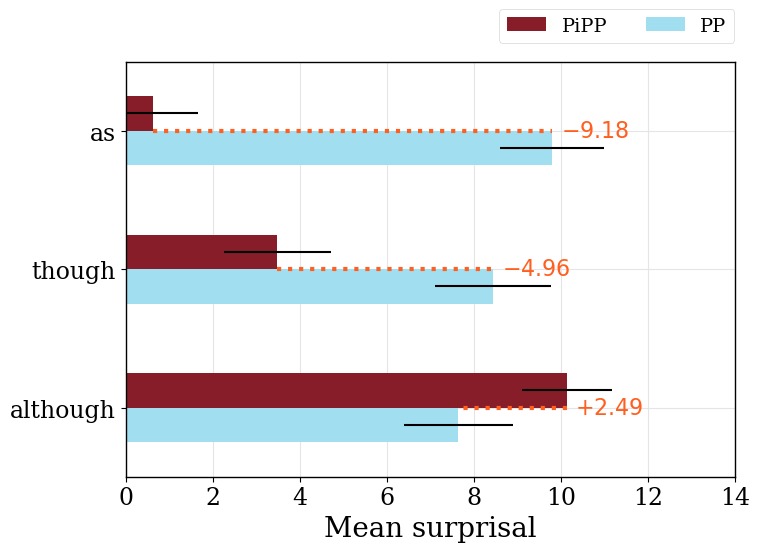

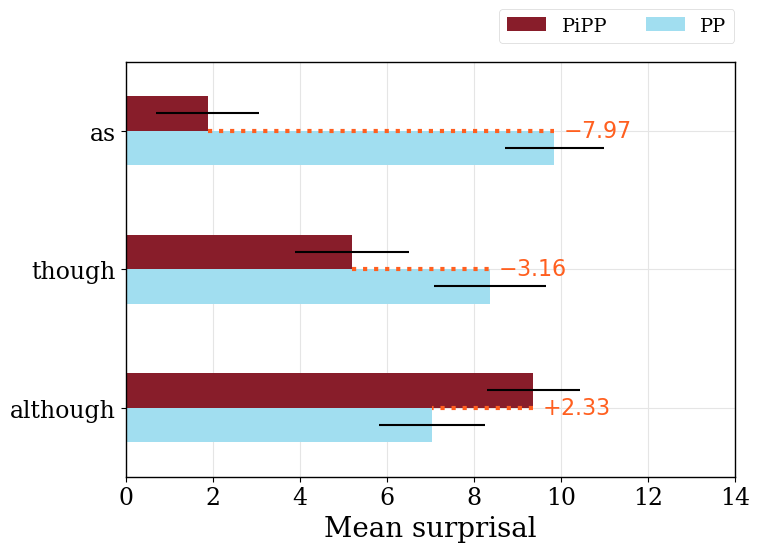

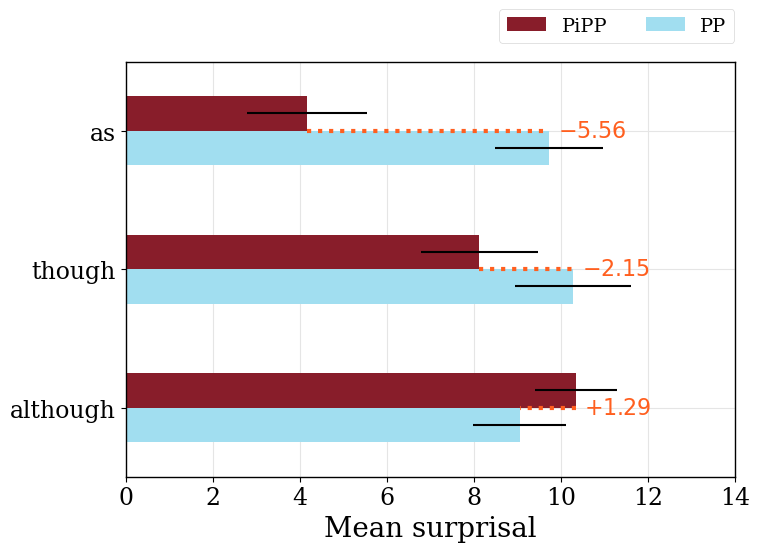

In [13]:
results = {}

for embname, emb in (("noembedding", ""), ("embedding1", "they said that"), ("embedding2", "they said that we knew that")):
    pp = masking_experiment(materials, condition='PP (No Filler/No Gap)', embedding=emb)
    pipp = masking_experiment(materials, condition='PiPP (Filler/Gap)', embedding=emb)
    masking_plot(pipp, pp, f"bert-pp-compare-{embname}.pdf")

## Ranking plots

In [14]:
def get_ranking_vocab(top_n=3):
    vocab = set()
    embeddings = ("", "they said that we knew that", "they said that")
    for embedding in embeddings:
        items = [utils.item(ex, preposition="[MASK]", embedding=embedding) for ex in materials]
        exs = [d['PiPP (Filler/Gap)'][0] for d in items]
        data = [masking_example(ex) for ex in exs]
        rankings = defaultdict(list)
        for d in data:
            words = [w.lower() for w, _ in d.items()][: top_n]
            vocab |= set(words)
    return vocab

In [15]:
def ranking_plot(output_filename, ranking_vocab, cond='PiPP (Filler/Gap)', embedding="", top_n=3):
    items = [utils.item(ex, preposition="[MASK]", embedding=embedding) for ex in materials]
    exs = [d[cond][0] for d in items]
    data = [masking_example(ex) for ex in exs]

    rankings = defaultdict(list)
    for d in data:
        words = [w.lower() for w, _ in d.items()][: top_n]
        for i, w in enumerate(words, start=1):
            rankings[i].append(w)

    ranks = [pd.Series(vals).value_counts() for vals in rankings.values()]
    rank_df = pd.concat(ranks, axis=1).fillna(0.0).T
    rank_df.index = list(range(1, top_n+1))
    for w in ranking_vocab:
        if w not in rank_df.columns:
            rank_df[w] = 0.0
    rank_df = rank_df[sorted(rank_df.columns)]

    ax = rank_df.plot.bar(stacked=True, legend=False, figsize=(6, 6), edgecolor='white')

    for i in range(top_n):
        t = -1
        for x, y in rank_df.iloc[i].items():
            if y > 0:
                ax.text(i, y + t, x, ha='center', fontsize=12)
                t += y

    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
    ax.set_xlabel("Rank")
    ax.set_ylabel("Experimental items")

    plt.tight_layout()
    plt.savefig(output_filename, dpi=500)

    return rank_df

In [16]:
ranking_vocab = get_ranking_vocab()

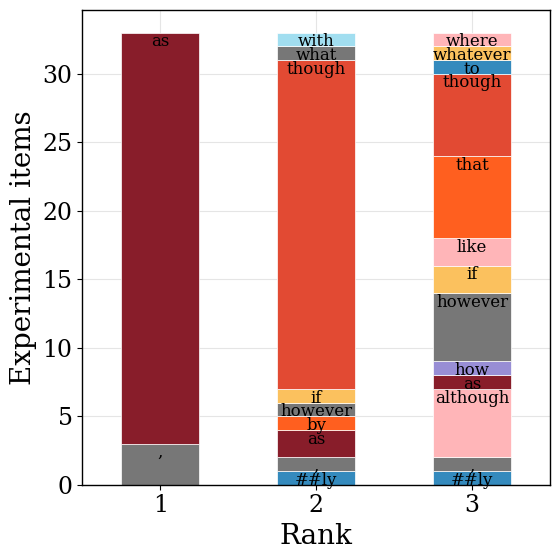

In [17]:
e0 = ranking_plot("results/prep-ranking-noembedding.pdf", ranking_vocab, top_n=3)

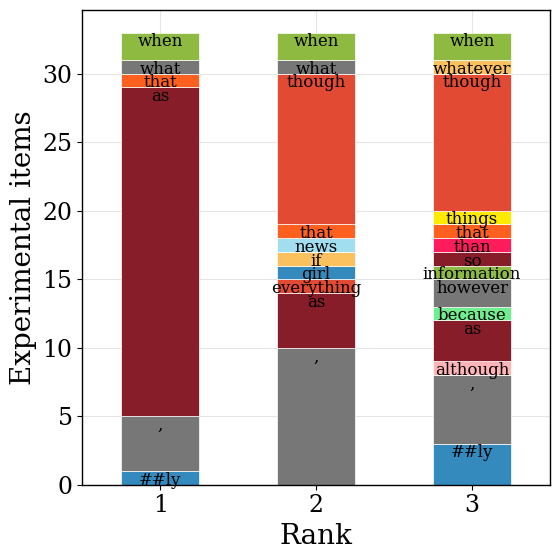

In [18]:
e1 = ranking_plot("results/prep-ranking-embedding1.pdf", ranking_vocab, embedding="they said that", top_n=3)

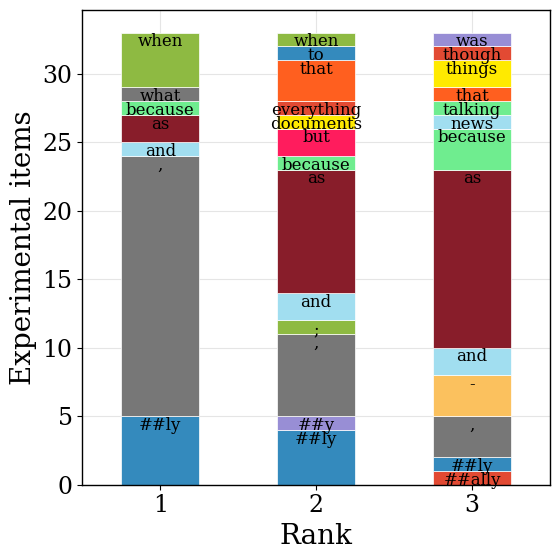

In [19]:
e2 = ranking_plot("results/prep-ranking-embedding2.pdf", ranking_vocab, embedding="they said that we knew that", top_n=3)